In [1]:
try:
    import opendatasets as od
except ImportError:
    !pip install opendatasets
    import opendatasets as od  # Import again after installation

# Download the dataset
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: detayotella
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 138MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
rice_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")

rice_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [4]:
rice_df.isnull().sum()

,0
id,0
Area,0
MajorAxisLength,0
MinorAxisLength,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Perimeter,0
Roundness,0


In [5]:
rice_df = rice_df.drop(columns=["id"], axis="columns")
rice_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [6]:
print(f"There are {rice_df.shape[1]} columns and {rice_df.shape[0]} rows in the dataset")

There are 11 columns and 18185 rows in the dataset


In [7]:
rice_df["Class"].nunique()

2

In [8]:
rice_df["Class"].value_counts()

,count
Class,
1,9985
0,8200


In [9]:
# Normalize the columns
original_rice_df = rice_df.copy()

for column in original_rice_df.columns:
    original_rice_df[column] = original_rice_df[column] / original_rice_df[column].abs().max()

original_rice_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [10]:
X = np.array(original_rice_df.iloc[:, :-1])
y = np.array(original_rice_df.iloc[:, -1])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42, stratify=y_test
)

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(1637, 10)
(3819, 10)


In [14]:
class RiceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [15]:
training_data = RiceDataset(X_train, y_train)
validation_data = RiceDataset(X_val, y_val)
testing_data = RiceDataset(X_test, y_test)

In [16]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)

In [17]:
for X, y, in train_dataloader:
    print(X)
    print("===================")
    print(y)
    break

tensor([[0.4738, 0.6266, 0.6720, 0.9056, 0.4509, 0.6883, 0.6647, 0.5546, 0.8446,
         0.5290],
        [0.5065, 0.7543, 0.5874, 0.9686, 0.4804, 0.7117, 0.6598, 0.6112, 0.7435,
         0.7285],
        [0.7402, 0.7737, 0.8319, 0.9049, 0.7002, 0.8603, 0.6794, 0.6754, 0.8899,
         0.5276],
        [0.8343, 0.8430, 0.8646, 0.9173, 0.8035, 0.9134, 0.7525, 0.7341, 0.8491,
         0.5532],
        [0.6966, 0.8072, 0.7567, 0.9376, 0.6610, 0.8346, 0.6070, 0.6936, 0.7940,
         0.6052],
        [0.9412, 0.8916, 0.9186, 0.9162, 0.8950, 0.9702, 0.7757, 0.7830, 0.8419,
         0.5507],
        [0.6703, 0.9057, 0.6505, 0.9787, 0.6389, 0.8187, 0.5144, 0.7265, 0.6966,
         0.7900],
        [0.8944, 0.8959, 0.8719, 0.9296, 0.8523, 0.9457, 0.6535, 0.7656, 0.8368,
         0.5830]], device='cuda:0')
tensor([1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0')


In [18]:
class MyModel(nn.Module):
    def __init__(self, input_features=X.shape[1], hidden_units=10):
        super().__init__()

        self.linear_layer = nn.Linear(in_features=input_features,
                                      out_features=hidden_units)
        self.linear = nn.Linear(in_features=hidden_units,
                                out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [19]:
from torchsummary import summary

summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [20]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [21]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10

for epoch in range(epochs):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    print(f"""Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
          Validation Loss: {round(total_loss_val/1000, 4)}, Validation Acc: {round(total_acc_val/validation_data.__len__() * 100, 4)}""")
    print("="*25)

Epoch no. 1 Train Loss: 0.6024 Train Accuracy: 91.2012
          Validation Loss: 0.0258, Validation Acc: 97.9841
Epoch no. 2 Train Loss: 0.1363 Train Accuracy: 98.3345
          Validation Loss: 0.0116, Validation Acc: 99.0226
Epoch no. 3 Train Loss: 0.087 Train Accuracy: 98.4366
          Validation Loss: 0.0086, Validation Acc: 98.9615
Epoch no. 4 Train Loss: 0.0754 Train Accuracy: 98.4445
          Validation Loss: 0.0076, Validation Acc: 99.0837
Epoch no. 5 Train Loss: 0.0722 Train Accuracy: 98.4759
          Validation Loss: 0.0071, Validation Acc: 99.0837
Epoch no. 6 Train Loss: 0.0704 Train Accuracy: 98.4916
          Validation Loss: 0.0069, Validation Acc: 99.0837
Epoch no. 7 Train Loss: 0.0695 Train Accuracy: 98.5466
          Validation Loss: 0.007, Validation Acc: 98.7783
Epoch no. 8 Train Loss: 0.0683 Train Accuracy: 98.5309
          Validation Loss: 0.0068, Validation Acc: 99.0837
Epoch no. 9 Train Loss: 0.0689 Train Accuracy: 98.5545
          Validation Loss: 0.0067, 

In [22]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for data in testing_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        total_loss_test += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc

    print(f"Accuracy: {round(total_acc_test/testing_data.__len__() * 100, 4)}")

Accuracy: 98.6646


<function matplotlib.pyplot.show(close=None, block=None)>

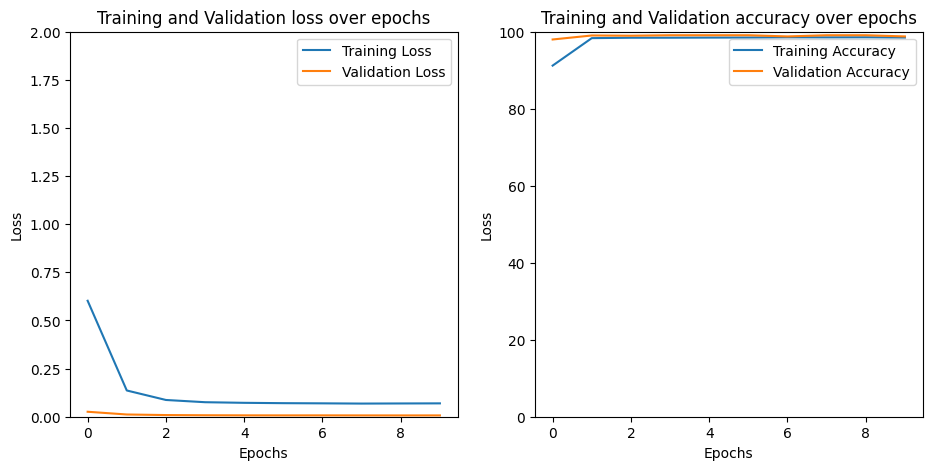

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim((0, 2))
axs[0].legend()


axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_val_plot, label="Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_ylim((0, 100))
axs[1].legend()

plt.show